# Part 2. A/B test inference

H0 : p  = p0 <p>H1  : p != p0</p>

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [3]:
data = pd.read_csv('ab_test_ensembles.csv')
data.head(7)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [5]:
pd.crosstab(data['group'], data['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [6]:
data.group.value_counts(normalize=True)

treatment    0.500126
control      0.499874
Name: group, dtype: float64

In [7]:
session_counts = data['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset.')

There are 0 users that appear multiple times in the dataset.


In [8]:
conversion_rates = data.groupby('group')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg(
    [np.mean, std_proportion, se_proportion]
    ).rename(
        columns={'mean':'CR mean',
                      '<lambda_0>':'CR std',
                      '<lambda_1>':'CR se'}
            )
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


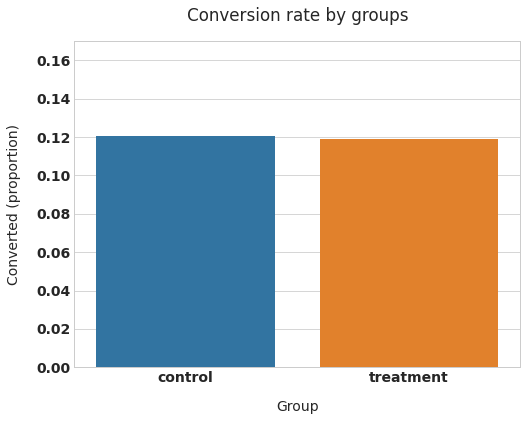

In [10]:
plt.figure(figsize=(8,6))
sns.barplot(x=data['group'], y=data['converted'], ci=False)
plt.ylim(0, 0.17)
plt.title('Conversion rate by groups', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [11]:
control_results = data[data['group'] == 'control']['converted']
treatment_results = data[data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Since the p-value=0.216 is above the α=0.05 threshold, the Null hypothesis Hₒ cannot be rejected, which means that the new variant did not perform significantly different than the standard one.

Additionally, the confidence interval for the treatment group ([0.117, 0.121], or 11.7-12.1%) does not have the target value of 15% (the 2% uplift) included.
What this means is that the treatment did not show any statistically significant change in conversion. Thus, the new variant is not likely to be an improvement, and it can be concluded that the treatment should not be implemented.

In [12]:
pd.crosstab(data['user_type'], data['variants'])

variants,standard,svm_ensemble_v_1_22
user_type,,
new_user,73797,73441
registered_user,73442,73798


In [13]:
data.user_type.value_counts(normalize=True)

registered_user    0.500003
new_user           0.499997
Name: user_type, dtype: float64

In [14]:
rate_user_type = data.groupby(['user_type', 'variants'])['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)
rate_user_type = rate_user_type.agg(
    [np.mean, std_proportion, se_proportion]
    ).rename(
        columns={'mean':'mean',
                 '<lambda_0>':'std',
                 '<lambda_1>':'se'}
            )
rate_user_type

mean       std        se
user_type       variants                                         
new_user        standard             0.121075  0.326215  0.001201
                svm_ensemble_v_1_22  0.117223  0.321686  0.001187
registered_user standard             0.119877  0.324818  0.001199
                svm_ensemble_v_1_22  0.120450  0.325488  0.001198

In [15]:
reg_users = data[data.user_type == 'registered_user']
new_users = data[data.user_type == 'new_user']

In [16]:
# registered users
reg_st_results = reg_users[reg_users['variants'] == 'standard']['converted']
reg_svm_results = reg_users[reg_users['variants'] == 'svm_ensemble_v_1_22']['converted']

n_reg_st =reg_st_results.count()
n_reg_svm= reg_svm_results.count()
success_reg = [reg_st_results.sum(), reg_svm_results.sum()]
nobs_r = [n_reg_st, n_reg_svm]

z_stat_r,pval_r = proportions_ztest(success_reg, nobs=nobs_r)
(lower_reg_st, lower_reg_svm), (upper_reg_st, upper_reg_svm) = proportion_confint(success_reg,
    nobs=nobs_r, alpha=0.05)

print(f'Z-statistic: {z_stat_r:.2f}')
print(f'p-value: {pval_r:.3f}')
print(f'CI 95% for a standard variant: [{lower_reg_st:.3f}, {upper_reg_st:.3f}]')
print(f'CI 95% for a new variant: [{lower_reg_svm:.3f}, {upper_reg_svm:.3f}]')

Z-statistic: -0.34
p-value: 0.735
CI 95% for a standard variant: [0.118, 0.122]
CI 95% for a new variant: [0.118, 0.123]


The p-value=0.735 is above the α=0.05 threshold, therefore the Null hypothesis Hₒ cannot be rejected, which means that the new variant did not perform significantly different than the standard one.
Thus, the new variant is not likely to be an improvement, and it can be concluded that the old version should be kept for registered users.

In [17]:
# new users
new_st_results = new_users[new_users['variants'] == 'standard']['converted']
new_svm_results = new_users[new_users['variants'] == 'svm_ensemble_v_1_22']['converted']

n_new_st = new_st_results.count()
n_new_svm = new_svm_results.count()
success_new = [new_st_results.sum(), new_svm_results.sum()]
nobs_n = [n_new_st, n_new_svm]

z_stat_n, pval_n = proportions_ztest(success_new, nobs=nobs_n)
(lower_new_st, lower_new_svm), (upper_new_st, upper_new_svm) = proportion_confint(success_new,
nobs=nobs_n, alpha=0.05)

print(f'Z-statistic: {z_stat_n:.2f}')
print(f'p-value: {pval_n:.3f}')
print(f'CI 95% for a standard variant: [{lower_new_st:.3f}, {upper_new_st:.3f}]')
print(f'CI 95% for a new variant: [{lower_new_svm:.3f}, {upper_new_svm:.3f}]')

Z-statistic: 2.28
p-value: 0.023
CI 95% for a standard variant: [0.119, 0.123]
CI 95% for a new variant: [0.115, 0.120]


The p-value=0.023 is below the α=0.05 threshold, therefore the Null hypothesis Hₒ can be rejected, which means that the new variant did perform significantly different than the standard one. Thus, the new variant of the page can be kept for new users.